In [26]:
import gymnasium as gym
import numpy as np
from utils import *

is_slippery = True
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=is_slippery)
print(env.reset())


(0, {'prob': 1})


In [22]:
def on_monte_carlo(iterations):
	epsilon = 0.1
	gamma = 0.95
	state_space = set(range(16))
	action_space = set(range(4))
	e_soft = epsilon / len(action_space)
	policy = np.full((16, 4), 0.25)
	Q = np.zeros((16, 4))
	returns = [[[0, 0] for _ in range(4)] for _ in range(16)] #sum, count instead of storing as lists
	eval_time_step = iterations // 1000
	returns_metric = []

	for iter in range(iterations):
		if iter % 100 == 0:
			print(f"Iteration: {iter}") #debug
		
		#Generate an episode
		episode = []
		is_end = False
		state = env.reset()[0]
		while is_end == False:
			action_prob = policy[state]
			action = np.random.choice(np.arange(4), p=action_prob)
			next_state, reward, is_end, _, _ = env.step(action)
			episode.append((state, action, reward))
			state = next_state

		#update
		G = 0
		episode_length = len(episode)
		for i in range(episode_length-1, -1, -1):
			current_state, current_action = episode[i][0], episode[i][1]
			G = gamma * G + episode[i][2]
			exists = any((prev_state, prev_action) == (current_state, current_action) for prev_state, prev_action, _ in episode[:i])
			if not exists:
				return_sum, count = returns[current_state][current_action]
				return_sum += G
				count += 1
				returns[current_state][current_action] = [return_sum, count]

				Q[current_state, current_action] = return_sum / count
				best_action = np.argmax(Q[current_state, :])
				for a in range(len(action_space)):
					policy[current_state][a] = (1 - epsilon + e_soft) if a == best_action else e_soft
		
		if iter % eval_time_step == 0:
			returns_metric.append(evaluate_policy(policy, env))

	return policy, returns_metric


policy, avg_returns = on_monte_carlo(iterations=50000)
print(policy)
visualize_policy(policy)



Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iter

↓ ↑ → ↑
→ · → ·
↑ ↓ ← ·
· → ↓ ·


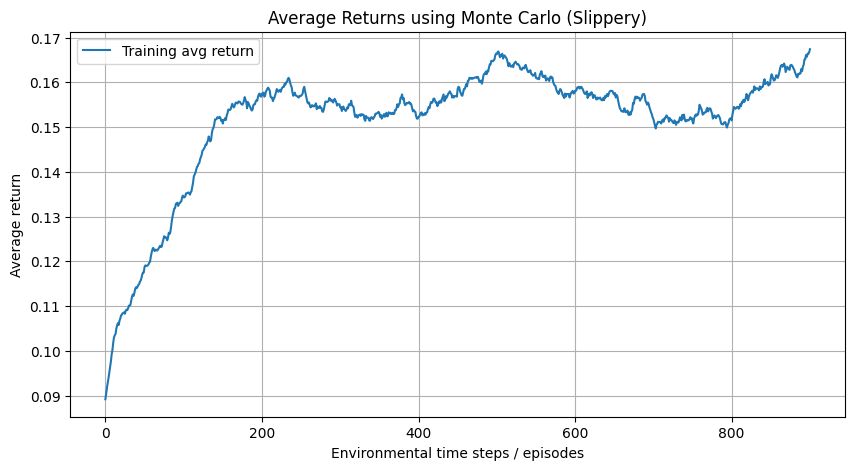

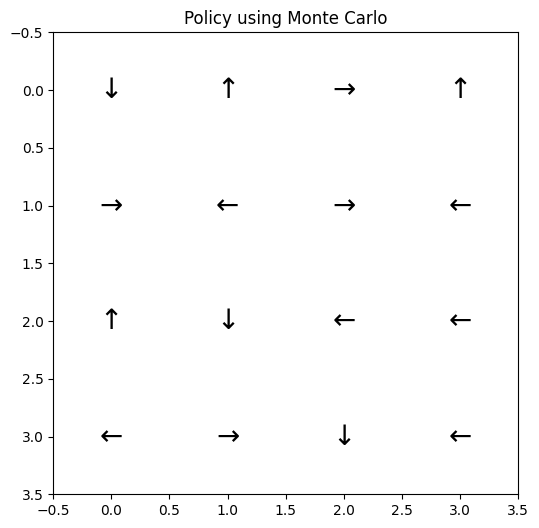

In [27]:
# print(policy)
def plot_eval(avg_returns, is_slippery, title):
	slippery_text = "(Slippery)" if is_slippery else "(Not Slippery)"

	plt.figure(figsize=(10,5))
	window=100
	avg_returns = np.convolve(avg_returns, np.ones(window)/window, mode='valid')
	plt.plot(np.arange(len(avg_returns)), avg_returns, label=f"Training avg return")

	plt.xlabel("Environmental time steps / episodes")
	plt.ylabel("Average return")
	plt.title(f"{title} {slippery_text}")
	plt.legend()
	plt.grid(True)
	plt.savefig(f"img/{title} {slippery_text}")
	plt.show()

def plot_policy(policy, is_slippery, title):
	grid_size = (4, 4)
	slippery_text = "(Slippery)" if is_slippery else "(Not Slippery)"
	action_arrows = {0:'←', 1:'↓', 2:'→', 3:'↑'}
	plt.figure(figsize=(6,6))
	plt.xlim(-0.5, grid_size[1]-0.5)
	plt.ylim(-0.5, grid_size[0]-0.5)
	plt.gca().invert_yaxis()
	
	for s in range(grid_size[0]*grid_size[1]):
		i, j = divmod(s, grid_size[1])
		best_a = np.argmax(policy[s])
		plt.text(j, i, action_arrows[best_a], ha='center', va='center', fontsize=20)
	
	plt.title(title)
	plt.savefig(f"img/{title} {slippery_text}")

visualize_policy(policy)
plot_eval(avg_returns, is_slippery, "Average Returns using Monte Carlo")
plot_policy(policy, is_slippery, "Policy using Monte Carlo")

In [ ]:
def evaluate_val_fn(Q, env):
	num_episodes = 100
	total_returns = 0
	max_steps = 100
	steps = 0
	for i in range(num_episodes):
		state, _ = env.reset()
		is_end = False
		G = 0
		while is_end == False and steps < max_steps:
			action = np.argmax(Q[state])
			state, reward, is_end, _, _ = env.step(action)
			G += reward
			steps += 1
		total_returns += G
	return total_returns / num_episodes

def SARSA(iterations, stepsize=0.2):	
	Q = np.zeros((16, 4))
	gamma = 0.95
	epsilon = 0.2
	eval_time_step = iterations // 1000
	returns_metric = []

	for iter in range(iterations):
		if iter % 100 == 0:
			print(f"Iteration: {iter}")
		state = env.reset()[0]
		action = np.random.choice(np.arange(4)) if np.random.rand() < epsilon else np.argmax(Q[state])
		is_end = False

		while is_end == False:
			next_state, reward, is_end, _, _ = env.step(action)
			next_action = np.random.choice(np.arange(4)) if np.random.rand() < epsilon else np.argmax(Q[next_state])

			Q[state, action] += stepsize * (reward + gamma * Q[next_state, next_action] * (not is_end) - Q[state, action])
			state = next_state
			action = next_action

		if iter % eval_time_step == 0 and iter != 0:
			returns_metric.append(evaluate_val_fn(Q, env))

	return Q, returns_metric


Q, avg_returns = SARSA(iterations=50000)
visualize_policy(Q)


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iter

In [ ]:
arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
plot_eval(avg_returns, is_slippery, "Average Returns using SARSA")
plot_policy(Q, is_slippery, "Policy using SARSA")
visualize_policy(Q)

In [29]:
def Q_learning(iterations, stepsize=0.2):
	Q = np.zeros((16, 4))
	gamma = 0.95
	epsilon = 0.1
	eval_time_step = iterations // 1000
	returns_metric = []
	
	for iter in range(iterations):
		if iter % 100 == 0:
			print(f"Iteration: {iter}")
	
		state = env.reset()[0] #initialize S

		is_end = False
		while is_end == False:
			action = np.random.choice(np.arange(4)) if np.random.rand() < epsilon else np.argmax(Q[state])
			next_state, reward, is_end, _, _ = env.step(action)

			Q[state, action] += stepsize * (reward + gamma * np.max(Q[next_state, :]) * (not is_end) - Q[state, action])
			state = next_state	
		
		if iter % eval_time_step == 0:
			returns_metric.append(evaluate_val_fn(Q, env))

	return Q, returns_metric

Q, avg_returns = Q_learning(iterations=50000)
visualize_policy(Q)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iter

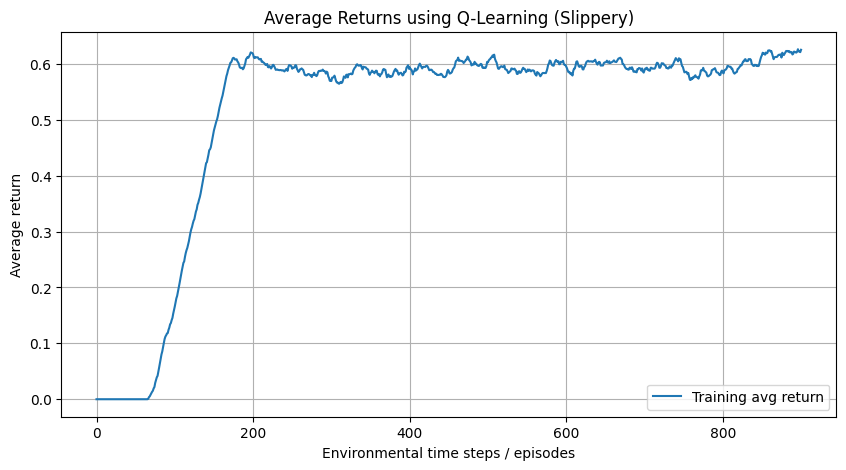

← ↑ ↓ ↑
← ← → ←
↑ ↓ ↓ ←
← → ↓ ←


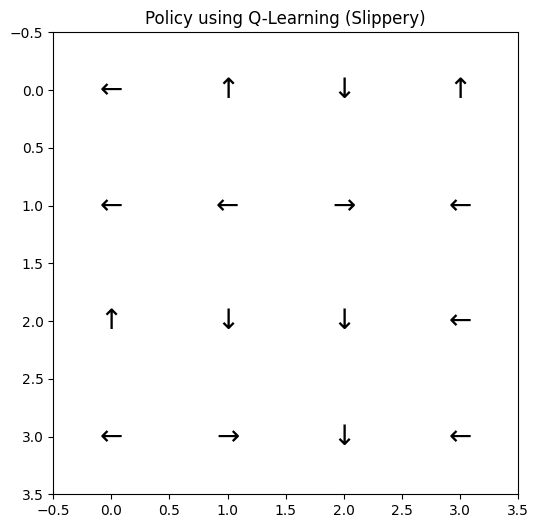

In [30]:
arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
plot_eval(avg_returns, is_slippery, "Average Returns using Q-Learning")
plot_policy(Q, is_slippery, "Policy using Q-Learning")
visualize_policy(Q)